****General Information****

All BraTS multimodal scans are available as NIfTI files (.nii.gz) --> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings

**T1: T1-weighted**, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.Used to show the structure and composition of different types of tissue in the brain and to identify tumors, cysts, and other abnormalities.

**T1c: T1-weighted**, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

**T2: T2-weighted image**, axial 2D acquisition, with 2–6 mm slice thickness. Used to show the fluid content of different types of tissue in the brain.

**FLAIR: T2-weighted FLAIR image**, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness. Used to suppress this fluid content. This can be useful for identifying lesions that are not clearly visible on T1 or T2 images, and also for identifying lesions in the white matter of the brain, which can be difficult to see on other types of scans.

**Segmented file name in Folder 355 has a false name. We renamed it to match the other files.**


In [7]:
#Import the needed libraries

import os
import numpy as np
import nibabel as nib
import glob
import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave as save
from cv2 import imread 
import keras.backend as K 
# import keras_cv
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
# pip install tensorflow==2.8
import tensorflow as tf
import keras 
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


First of all, we are using this part of code to understand the dataset and below we split the code/process to parts, for better organizing the whole project.

**STEP 1:** Load some samples from the training dataset and visualise the data.

a)Rename the file infolder #355

b)Divide each image by its max to scale them between [0,1]

c)Convert mask from float to uint8

d)Change mask pixel values (labels) from 4 to 3 (as the original labels are 0, 1, 2, 4)

e)Label categories: 
- 0: Unlabeled volume
- 1: Necrotic and non-enhancing tumor core (NCR/NET)
- 2: Peritumoral edema (ED)
- 3: Missing (No pixels in all the volumes) --> we ignore this label as all the volumes have images
- 4: GD-enhancing tumor (ET)


File is ok
[0 1 2 4]
[0 1 2 3]


<Figure size 1200x800 with 0 Axes>

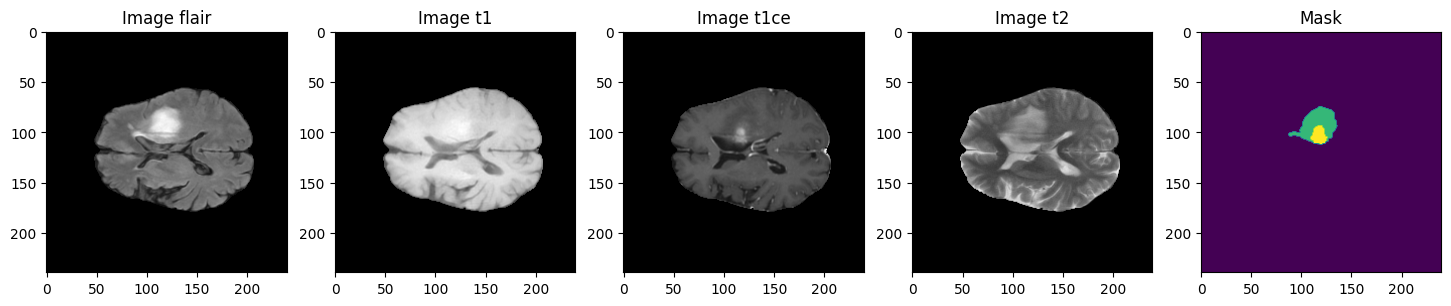

In [9]:
#Visualize

TRAINING_DATASET_PATH ="E:/BraTS Training & Validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
VALIDATION_DATASET_PATH = "E:\BraTS Training & Validation/BraTS2020_ValidationData\MICCAI_BraTS2020_ValidationData"

#Rename the problemmatic seg file in the folder 355
import os
source_name='/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii'
destination_name='/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii'

if os.path.exists(source_name):
  os.rename(source_name,destination_name)
  print ('File {source_name} renamed')
else:
  print ('File is ok')

#Reshape the data and convert them to 1D and after that we reshape to the original shape.
test_image_flair=nib.load(TRAINING_DATASET_PATH+'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
# print(test_image_flair)
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1,test_image_flair.shape[-1])).reshape(test_image_flair.shape)
# print(test_image_flair)

test_image_t1=nib.load(TRAINING_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAINING_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAINING_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAINING_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))  # Status after reassignment

#Import random to take a random slice of the file.
import random
# n_slice=random.randint(0, test_mask.shape[2]) #Here we generate a random integer between 0 and test_mask.shape[2] (which is 155)
n_slice=80
# print(test_mask.shape[2]) #Test

plt.figure(figsize=(12, 8))

# plt.subplot(231)
# plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
# plt.title('Image flair')
# plt.subplot(232)
# plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
# plt.title('Image t1')
# plt.subplot(233)
# plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(234)
# plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
# plt.title('Image t2')
# plt.subplot(235)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.tight_layout()
# plt.show()

############# To plot in the same line #############

n_slice = 80

plt.figure(figsize=(18, 8))  # Adjust the figsize as needed

# Plot the first image
plt.subplot(1, 5, 1)  # 1 row, 4 columns, position 1
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')

# Plot the second image
plt.subplot(1, 5, 2)  # 1 row, 4 columns, position 2
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')

# Plot the third image
plt.subplot(1, 5, 3)  # 1 row, 4 columns, position 3
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')

# Plot the fourth image
plt.subplot(1, 5, 4)  # 1 row, 4 columns, position 4
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')

# Plot the fifth image
plt.subplot(1, 5, 5)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.show()


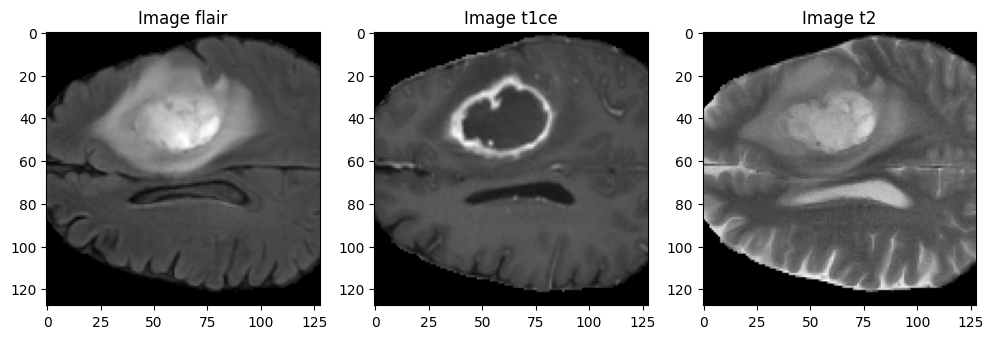

[[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  ...

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]


 [[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]

  [[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   ...
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0

In [11]:
#PART 2: Explore the process of combining images to channels and divide them to patches
#Combining all 4 image types (t1ce,t2,flair,seg) to 4 channels of a numpy array.
#
################################################
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image to use the dataset more efficiently.

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

# n_slice=random.randint(0, test_mask.shape[2])
n_slice=80
plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')
# plt.subplot(222)
# plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(223)
# plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')

plt.subplot(1,3,1)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(1,3,2)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(1,3,3)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
plt.show()

##################
#This is optional#
##################

# save('E:/BraTS Training & Validation/BraTS2020_TrainingData/combined255.tif', combined_x)
# np.save('E:/BraTS Training & Validation/BraTS2020_TrainingData/combined355.npy', combined_x)
# #Verify image is being read properly

# my_img=imread('E:/BraTS Training & Validation/BraTS2020_TrainingData/combined255.tif')
# my_img=np.load('E:/BraTS Training & Validation/BraTS2020_TrainingData/combined355.npy')

# print(combined_x==my_img) #Validating that the combined_x is exactly equal to my_img
#Using to_categorical from Keras.utils (Converts a class vector (integers) to binary class matrix) 
print (test_mask)
test_mask = to_categorical(test_mask, num_classes=4)
print (test_mask) # Here we can check the normalized values we did on previous step.

#####################################
#End of understanding the dataset. Now get it organized for processing it.
#####################################

In [12]:
####################### START OF PROCESSING OF TRAIN DATA #######################
#Applying the above logic to all the images
#Steps as in test are: Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE
import os
#Keras datagenerator does not support 3d, so we can proceed by creating a custom data generator to handle the 3d files.
IMAGES_INPUT_PATH="E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_3channels/images"
MASKS_INPUT_PATH="E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_3channels/masks"

###Creating the directories we need to use for storing the combined np arrays

# Directory
directory = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_3channels"

# Check whether directory already exists. If exists show the appropriate message.
if not os.path.exists(directory):
  os.mkdir(directory)
  print("Folder %s created!" % directory)
else:
  print("Folder %s already exists" % directory)

if os.path.exists(directory) and not (os.path.exists(IMAGES_INPUT_PATH) or os.path.exists(MASKS_INPUT_PATH)):
  os.mkdir(IMAGES_INPUT_PATH)
  os.mkdir(MASKS_INPUT_PATH)
  print("Folder %s created!" % IMAGES_INPUT_PATH)
  print("Folder %s created!" % MASKS_INPUT_PATH)
else:
  print("Folder %s already exists" % IMAGES_INPUT_PATH,MASKS_INPUT_PATH)

################################################################################

# Lists with images per type t1,t2,t1ce,flair,seg
#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii')) #!We exclude the t1 images, as we have t1ce, which is the same but in better contrast
t2_list = sorted(glob.glob(TRAINING_DATASET_PATH+'/*/*t2.nii'))
t1ce_list = sorted(glob.glob(TRAINING_DATASET_PATH+'/*/*t1ce.nii'))
flair_list = sorted(glob.glob(TRAINING_DATASET_PATH+'/*/*flair.nii'))
mask_list = sorted(glob.glob(TRAINING_DATASET_PATH+'/*/*seg.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata() #The T2-weighted MRI image is loaded using the nibabel library (nib.load) and converted to a NumPy array (get_fdata()).
    # print("Before scaling")        ####################################################################################
    # print(temp_image_t2.shape)     #This is for test to see how we change variety/scale of values, by using the scaler#
    # print(temp_image_t2.max())     ####################################################################################
    
    #The image values are then scaled using a scaler (likely a normalization step), which adjusts the variety or scale of values. 
    #The image is reshaped into a 2D array, scaled, and then reshaped back to its original shape. This is done to normalize the image data before feeding it into a machine learning model.
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape) 
    # print("After scaling")         ####################################################################################
    # print(temp_image_t2.shape)     #This is for test to see how we change variety/scale of values, by using the scaler#
    # print(temp_image_t2.max())     ####################################################################################
    
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata() 
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
    # print('temp_image_t1ce.size: ',temp_image_t1ce.size)
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
    # print('temp_image_flair.size: ',temp_image_flair.size)
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    # print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    print(temp_combined_images.shape)
    
    # print('test',temp_combined_images)
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True) #Here we count the number of values of each category (0,1,2,3) separately
    print(val,counts) # Here we print the count of each category (0,1,2,3)
    
    # Produce the numpy files which will be used to our data generator. With the below check
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0 (background)
        if (len(os.listdir(IMAGES_INPUT_PATH))==0 and len(os.listdir(MASKS_INPUT_PATH)==0)): #Extra check as this code is running for long time and if the folders are already populated it is good to avoid it
            print("Save Me")
            temp_mask= tf.keras.utils.to_categorical (temp_mask, num_classes=4)
            np.save(IMAGES_INPUT_PATH+'/image_'+str(img)+'.npy', temp_combined_images)
            np.save(MASKS_INPUT_PATH+'/mask_'+str(img)+'.npy', temp_mask)
        else:
            print("The folders are already populated")
            break
    else:
        print("I am useless")   

Folder E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_3channels already exists
Folder E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_3channels/images already exists E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_3channels/masks
Now preparing image and masks number:  0
(240, 240, 155, 3)
[0 1 2 3] [1886119   15443  167848   27742]
The folders are already populated


In [13]:
import os

# Specify path of BraTS2020 directory
data_path = "E:/BraTS Training & Validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

# Retrieve all samples from path with listdir(). 
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

csv_files = [file for file in samples if file.endswith('.csv')] #Find the csv files.


if csv_files:
    print (f"There are {len(csv_files)} CSV files in folder")
    print (f"Files ",csv_files, "are going to be removed")
    for file in csv_files:
        csv = ''.join(file)
        csv_path = os.path.join(data_path,file)
        os.remove(csv_path)
    
else:
    print ("There are no CSV files.")

Number of samples: 369
There are no CSV files.


In [11]:
# pip install split-folders

In [14]:
#Split training data into train and validation
"""
Code for splitting folder into train and validation data.
Once the new folders are created rename them and arrange in the format below to be used
for semantic segmentation using data generators. 

For importing the splitfolders we need to run, if it's not already installed:
pip install split-folders
"""
import splitfolders
import os

input_folder = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_3channels/"
output_folder = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/"

if not os.path.exists(output_folder):
  os.mkdir(output_folder)
  print("Folder %s created!" % output_folder)
else:
  print("Folder %s already exists" % output_folder)

#We are going to split the folder with a ratio of 75% train and 25% validation data, consisting of 128*128*128 arrays
if not os.listdir(output_folder):
    splitfolders.ratio(input_folder, output=output_folder, seed=45, ratio=(0.75, 0.25), group_prefix=None) # default values
    print("Data split completed.")
else:
    print("The split of the data is already completed")

#We are going to split the folder with a ratio of 75% train and 25% validation data, consisting of 128*128*128 arrays

Folder E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/ already exists
The split of the data is already completed


E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/images/


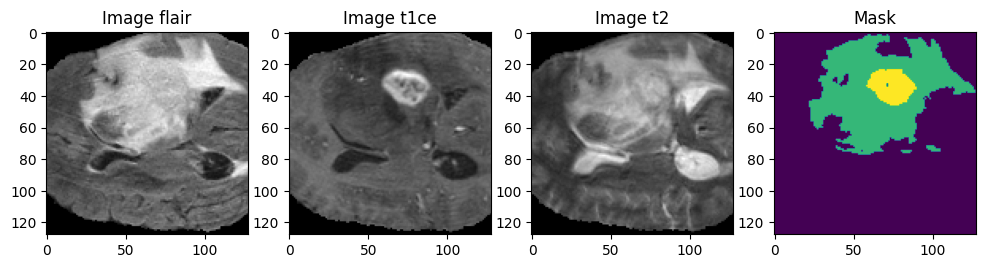

In [18]:
"""
Custom data generator to work with BraTS2020 dataset.
No image processing operations are performed here, just load data from local directory in batches. Image processing performed in the previous sheets.
"""

#from tifffile import imsave, imread
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'): #Check the file type to be 'npy'
          
            image = np.load(img_dir+image_name) #Load the images using NumPy
            
            images.append(image) #Append the image np array to the list
    images = np.array(images) #The list of loaded images is converted to NumPy
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list) #Length of the image list
    '''
    keras needs the generator infinite, so we will use while true. 
    The logic below is to process the data partially (in batches) to avoid heavy load in the memory by loading the entire dataset. 
    yield keyword helps us create this generator  
    '''
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit]) # Here we use the load_img function
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #Here we return a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size #Here we increment the batch every time by the value we set on batch_size
            batch_end += batch_size

#######################################Alternative code
# def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
#     while True:
#         for batch_start in range(0, len(img_list), batch_size):
#             limit = min(batch_start + batch_size, len(img_list))
#             
#             # Load images
#             X = load_img(img_dir, img_list[batch_start:limit])
# 
#             # Load masks
#             Y = load_img(mask_dir, mask_list[batch_start:limit])
# 
#             # ... Rest of the code ...
# 
#             # Print image and mask shapes for debugging
#             print("X shape:", X.shape)
#             print("Y shape:", Y.shape)
# 
#             # Reshape images and masks
#             X = np.reshape(X, (batch_size, 128, 128, 128, 3))
#             print('size', X.size)
#             print('The reshaped X table is:' ,X)
#             Y = np.reshape(Y, (batch_size, 128, 128, 128, 4))
#             print('y size', Y.size)
#             print ("The reshaped Y table is:" ,Y)
# 
#             # ... Rest of the code ...
# 
#             yield X, Y
# 
# def load_img(img_dir, img_list):
#     images = []
#     for image_name in img_list:
#         image = np.load(img_dir + image_name)  # Load the images using NumPy
#         images.append(image)
#     return np.array(images)


############################################

#The below code is used to test the data generators

from matplotlib import pyplot as plt
import random

train_img_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
print(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__() #Here we produce img, mask which consists from 2(img)*128*128*128*3 (channels) and 2(masks)*128*128*128*4 (categorical channels)


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')
# plt.subplot(222)
# plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(223)
# plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()


# Plot the first image
plt.subplot(1, 4, 1)  # 1 row, 4 columns, position 1
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')

# Plot the second image
plt.subplot(1, 4, 2)  # 1 row, 4 columns, position 2
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')

# Plot the third image
plt.subplot(1, 4, 3)  # 1 row, 4 columns, position 3
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')

# Plot the fourth image
plt.subplot(1, 4, 4)  # 1 row, 4 columns, position 4
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

plt.show()

In [19]:
"""

NEW Converted 3DUnet with only one dropout at the end of contracting path. 

"""

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #This works for ReLU activation function


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    c5 = Dropout(0.5)(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 conv3d_1 (Conv3D)              (None, 128, 128, 12  6928        ['conv3d[0][0]']                 
                                8, 16)                                                        

In [ ]:
"""

COPY of the old Converted 3DUnet with dropouts in each CNN

"""

from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #This works for ReLU activation function


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1) 
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2) 
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8) 
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9) 
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

In [18]:
# pip install segmentation-models-3D==1.0.5
# pip install scikit-image

In [23]:

"""

# Code to train batches of cropped BraTS 2020 images using 3D U-net.

# Please get the data ready and define custom data gnerator using the other
# files in this directory.

# Images are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for 
#                                                   test_image_flair, test_image_t1ce, test_image_t2)
# Change the U-net input shape based on your input dataset shape (e.g. if you decide to only use 2 channels or all 4 channels)

# Masks are expected to be 128x128x128x4 npy data (4 corresponds to the 4 classes / labels)


# You can change input image sizes to customize for your computing resources.
 """


import os
import numpy as np
import tensorflow as tf
import keras
from keras.optimizers import Adam
from matplotlib import pyplot as plt
import glob
import random
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard
import pickle
import segmentation_models_3D as sm



####################################################
train_img_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))
print("The number of images is: ",num_images)

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
print('test_img size',test_img.shape)
test_mask = np.load(train_mask_dir+msk_list[img_num])
print('test_mask size', test_mask.shape)
test_mask = np.argmax(test_mask, axis=3)


n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

#############################################################
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

# import pandas as pd
# columns = ['0','1', '2', '3']
# df = pd.DataFrame(columns=columns)
# train_mask_list = sorted(glob.glob('E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
# for img in range(len(train_mask_list)):
#     print(img)
#     temp_image=np.load(train_mask_list[img])
#     temp_image = np.argmax(temp_image, axis=3)
#     val, counts = np.unique(temp_image, return_counts=True)
#     zipped = zip(columns, counts)
#     conts_dict = dict(zipped)
    
#     df = df.append(conts_dict, ignore_index=True)

## The label here represents the number of pixels labeled for each class.

# label_0 = df['0'].sum()
# label_1 = df['1'].sum()
# label_2 = df['1'].sum()
# label_3 = df['3'].sum()
# total_labels = label_0 + label_1 + label_2 + label_3
# n_classes = 4
# #Class weights claculation: n_samples / (n_classes * n_samples_for_class)
# wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
# wt1 = round((total_labels/(n_classes*label_1)), 2)
# wt2 = round((total_labels/(n_classes*label_2)), 2)
# wt3 = round((total_labels/(n_classes*label_3)), 2)

# #Weights are: 0.26, 22.53, 22.53, 26.21
# #wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
# #These weihts can be used for Dice loss 


# print(wt0)
# print(wt1)
# print(wt2)
# print(wt3)



# #These weihts can be used for Dice loss 

# ##############################################################
# #Define the image generators for training and validation

train_img_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
 
# # ##################################Test to val data
# # val_img=np.load(val_img_dir+val_img_list[0])
# # print(val_img.size)
# # print(val_img.shape)
# # ########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# # ###########################################################################
# #Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25


## Loss setup
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
# iou_loss = keras_cv.losses.IoULoss()

## Metrics setup
f_score=sm.metrics.FScore() # Dice coefficient from segmentation models
recall=tf.keras.metrics.Recall()
mean_iou=tf.keras.metrics.MeanIoU(num_classes=4)
iou=sm.metrics.IOUScore()

#Precision

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
# # total_loss = dice_loss + (1 * focal_loss) #Using 1 * focal_loss as a weight to emphasize the focal_loss weight. The weight can be tuned.
losses = ['categorical_crossentropy',dice_loss,focal_loss]
metrics = ['accuracy',iou,precision,recall,f_score,dice_loss]

LR = 0.0001 #learning rate for Adam optimizer --> Values 0.0001 or 0.001 are considered default !!!!!!!!!! For 200 epochs training adjusted from 0.0001 to 0.001 with min_lr=0.0001 set in callbacks.

optim = Adam(learning_rate=LR) 

#######################################################################
## Fit the model 
# log_dir='C:/Users/Dimitris Sinanis/PycharmProjects/MSc_Diploma/venv/tensorboard/1st_method' #For tensorboard
# steps_per_epoch = len(train_img_list)//batch_size
# val_steps_per_epoch = len(val_img_list)//batch_size

# ###simple_unet_model=simple_unet_model()

# model = simple_unet_model(IMG_HEIGHT=128, 
#                           IMG_WIDTH=128, 
#                           IMG_DEPTH=128, 
#                           IMG_CHANNELS=3, 
#                           num_classes=4)

# model.compile(optimizer = optim,loss=losses,metrics=metrics)

# print(model.summary())

# print(model.input_shape)
# print(model.output_shape)

# callbacks = [
#     keras.callbacks.ReduceLROnPlateau(monitor='categorical_crossentropy', factor=0.2,
#                               patience=2, min_lr=0.0001, verbose=1), #Changed LR from min_lr=0.000001
#     TensorBoard(log_dir=log_dir, write_images=True),

#     CSVLogger(r'C:\Users\Dimitris Sinanis\PycharmProjects\MSc_Diploma\venv\tensorboard\1st_method\train\training_3d_10epoch_final_default.log', separator=',', append=False),
    
#     # MetricsPerClass(validation_data=(X_val, y_val))
# ]

# history=model.fit(train_img_datagen,
# steps_per_epoch=steps_per_epoch, #was steps_per_epoch changed for testing to 10
# epochs=200,
# verbose=1,
# callbacks=callbacks,
# validation_data=val_img_datagen,
# validation_steps=val_steps_per_epoch,
# )

# model.save(r'C:\Users\Dimitris Sinanis\PycharmProjects\MSc_Diploma\venv\HDF5 Models_1st Method\training_3d_10epoch_final_default.hdf5')


ImportError: cannot import name 'Adam' from 'keras.optimizers' (c:\Anaconda3\envs\tensorflow-gpu_1\lib\site-packages\keras\optimizers.py)

In [20]:
################ This part is used for predictions ################

from keras.models import load_model
import segmentation_models_3D as sm

## Load model for prediction

## Here, we need to add all the metrics we used during our training to load the model. Alternatively, we will have an error.

my_model = load_model(r"C:\Users\Dimitris Sinanis\PycharmProjects\MSc_Diploma\venv\HDF5 Models_1st Method\training_3d_200epoch_final_default.hdf5", 
                      custom_objects={'categorical_crossentropy': 'categorical_crossentropy',
                                      'iou_score':iou,
                                      'dice_loss': dice_loss,
                                      'focal_loss': focal_loss,
                                      'f1-score': f_score,
                                      'precision': precision,
                                      'recall': recall})



#################################################

########## Function to read the image, this is optional step so keep this commented out except if you want to see how it works.
# import cv2
# import numpy as np

# def preprocess_image(image_path, target_size=(128, 128)):
#     # Load the image using OpenCV
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

#     # Check if the image is loaded successfully
#     if img is None:
#         raise FileNotFoundError(f"Error loading image at path: {image_path}")

#     # Resize the image to the target size
#     img = cv2.resize(img, target_size)

#     # Normalize pixel values to the range [0, 1]
#     img = img / 255.0

#     # Expand dimensions to make it compatible with model input shape (assuming the model expects a batch dimension)
#     img = np.expand_dims(img, axis=0)

#     return img

################## End ##################


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#The code loads a batch of images and masks from the validation dataset, uses our trained segmentation model to predict the masks for these images, 
#computes the IoU metric between the predicted and true masks, and prints the mean IoU score. This provides an evaluation metric to assess the performance of our segmentation model.
from keras.metrics import MeanIoU

train_img_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size=4 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#############################################
#Predict on a few test images, one at a time
#Try images: 
img_num = 237

#### Not working, it needs the data to be preprocessed to show the predictions as we have worked with three channels and dimensions 128x128x128
# test_img = nib.load(r"F:\BraTS2023\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData\BraTS-GLI-00000-000\BraTS-GLI-00000-000-t1c.nii\00000057_brain_t1ce.nii").get_fdata()
test_img=np.load(r"F:\BraTS Training & Validation\BraTS2020_TrainingData\input_data_128\val\images\image_"+str(img_num)+".npy")
test_mask = np.load("E:/BraTS Training & Validation/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)


test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

################# Code for plotting images


# test_img_input = r"C:\Users\Dimitris Sinanis\Desktop\Εικόνες Διπλωματικής\MRI_max_avg_pooling.png"
# test_img = preprocess_image(test_img_input)

# # Predict using the loaded model
# test_prediction = my_model.predict(test_img)
# test_prediction_argmax = np.argmax(test_prediction, axis=4)[0, :, :, :]

# # Verify shapes
# print("Shapes - Test Image:", test_img.shape)
# print("Shapes - Test Prediction:", test_prediction_argmax.shape)

# # Plotting
# n_slice = 50  # Change this according to your requirements
# plt.figure(figsize=(12, 8))
# plt.subplot(231)
# plt.title('Testing Image')
# plt.imshow(test_img[0, :, :, 0], cmap='gray')  # Assuming it's a single-channel image
# # Add more subplots for other images as needed
# plt.show()

################### End

# print(test_prediction_argmax.shape)
# # print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


# #Plot individual slices from test predictions for verification
# from matplotlib import pyplot as plt
# import random

# #n_slice=random.randint(0, test_prediction_argmax.shape[2])
# n_slice = 80
# plt.figure(figsize=(12, 8))
# plt.subplot(231)
# plt.title(f'Testing Image: {img_num}')
# plt.imshow(test_img[:,:,n_slice,0], cmap='gray')
# plt.subplot(232)
# plt.title('Ground Truth')
# plt.imshow(test_mask_argmax[:,:,n_slice])
# plt.subplot(233)
# plt.title('Prediction on test image')
# plt.imshow(test_prediction_argmax[:,:, n_slice])
# plt.show()

####################### Additional method to print class names as legend - We used this as this provides a better plot #######################

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import random

# Assuming these are the class names
class_names = ['Not Tumor', 'Non-Enhancing Tumor class 1', 'Edema class 2', 'Enhancing Tumor class 3']  # Add your actual class names
# Assuming these are the colors used in your segmentation
class_colors = ['#440054', '#3b528b', '#18b880', '#e6d74f']  # Adjust colors as per your class

# Plot individual slices from test predictions for verification
# n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 60
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title(f'Testing Image: {img_num}')
plt.imshow(test_img[:,:,n_slice,0], cmap='gray')
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])

# Create custom legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(class_colors, class_names)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()


############################################################

Segmentation Models: using `tf.keras` framework.


NameError: name 'iou' is not defined

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

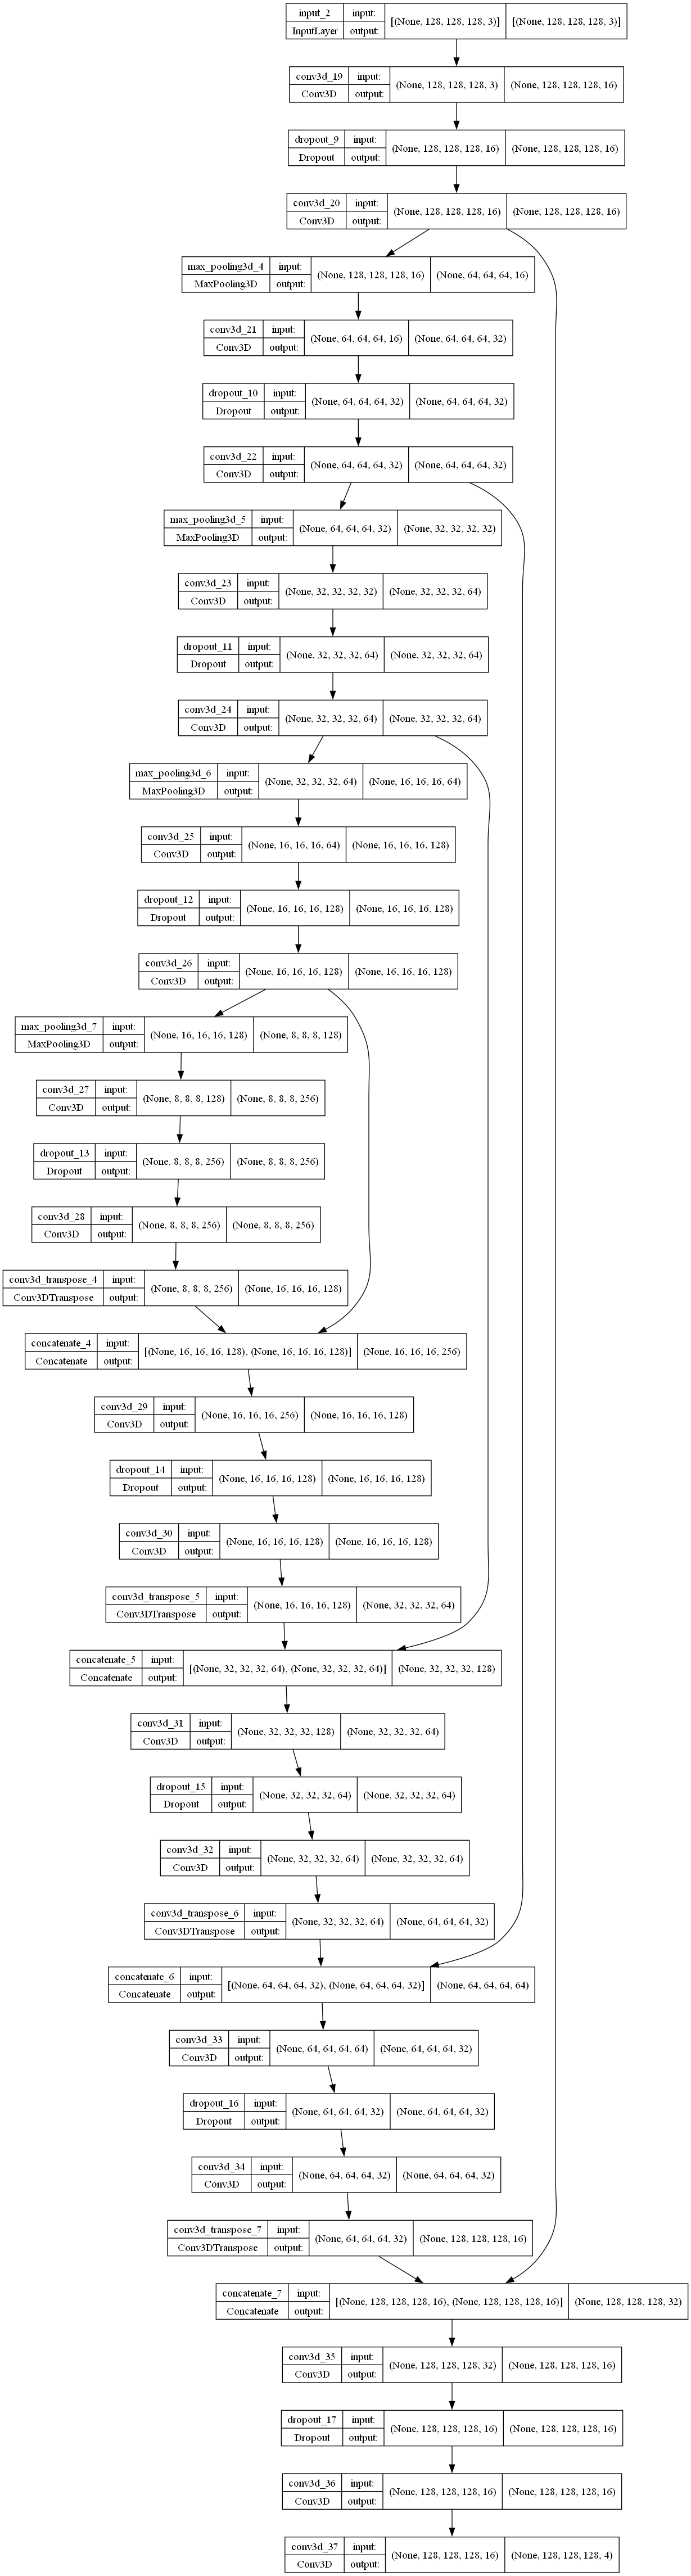

In [ ]:
############# Plot the model's architecture #############

from keras.models import load_model
from keras.utils.vis_utils import plot_model
import segmentation_models_3D as sm

# ['categorical_crossentropy',dice_loss,focal_loss]
# metrics = ['accuracy',iou,precision,recall,f_score,dice_loss,focal_loss]

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
# iou_loss = keras_cv.losses.IoULoss()

## Metrics setup
f1_score=sm.metrics.FScore() # Dice coefficient from segmentation models
recall=tf.keras.metrics.Recall()
mean_iou=tf.keras.metrics.MeanIoU(num_classes=4)
iou=sm.metrics.IOUScore()

# Load your pre-trained 3D U-Net model
model = load_model(r"C:\Users\Dimitris Sinanis\PycharmProjects\MSc_Diploma\venv\HDF5 Models_1st Method\brats_3d_200epoch_final.hdf5", 
                      custom_objects={'iou_score':sm.metrics.IOUScore(threshold=0.5),
                                      'dice_loss': dice_loss,
                                      'focal_loss': focal_loss,
                                      'f1-score': f1_score,
                                      'precision':precision
                                      })

# Display model architecture
model.summary()

# Plot the model architecture
plot_model(model, to_file=r'C:\Users\Dimitris Sinanis\PycharmProjects\MSc_Diploma\venv\HDF5 Models_1st Method\pretrained_3d_unet_architecture.png', show_shapes=True, show_layer_names=True)
